In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
import csv

from dataloaders.osm_dataloader import OSMDataset
from dataloaders.osm_datagenerator import DataGeneratorOSM
from dataloaders.dataset_helper import findallimagesosm

from models.Unet_keras import buildUnet
from dataloaders.img_helper import show_sample, show_sample_gt


In [ ]:
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [ ]:
#functions for the loss
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

# Dataset loading

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


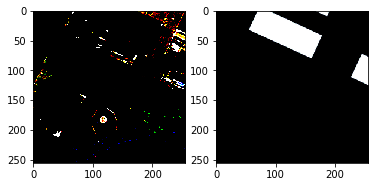

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


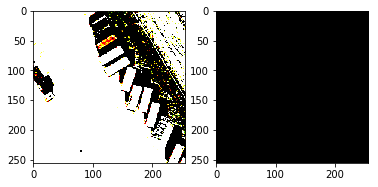

In [4]:
 # Datasets
partition, labels = findallimagesosm(folder = '/data/khokhlov/datasets/OSM_processed_margo/')

params = {'dim': (256, 256),
          'batch_size': 32,
          'n_channels_img':3,
          'n_channel_mask':1,
          'shuffle': True}
max_epochs = 100



masks_coverage = {}
file_name_coverage = 'train.csv'
with open(file_name_coverage) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        masks_coverage[row['ID']] = row['val']

training_generator = DataGeneratorOSM(partition['train'], labels['train'], coverage=masks_coverage, stratified_sampling = True, **params)
validation_generator = DataGeneratorOSM(partition['validation'], labels['validation'], **params)

(X,y) = training_generator. __getitem__(0)
show_sample(X[0,:].astype(int), np.squeeze(y[0,:]))

(X,y) = validation_generator. __getitem__(0)
show_sample(X[0,:].astype(int), np.squeeze(y[0,:]))


## Training parameters

In [5]:
loss_history = []
weight_path = "modelssaved/{}_weights.best.hdf5".format('vgg_unet')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto',
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=7)  # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]




## Model

In [6]:
unet_model = buildUnet(X, y) # to initialize the parameters correctly
unet_model.compile(optimizer=Adam(1e-3, decay=1e-4),
                   loss=binary_crossentropy,
                   metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [7]:

loss_history += [unet_model.fit_generator(generator=training_generator, steps_per_epoch=50,
                                          epochs=10,
                                          validation_data=validation_generator, validation_steps=10,
                                          use_multiprocessing=False,
                                          callbacks=callbacks_list)]

Epoch 1/10
50/50 [==============================] - 85s 2s/step - loss: 1.0383 - dice_coef: 0.4638 - binary_accuracy: 0.7150 - true_positive_rate: 0.5990 - val_loss: 0.4328 - val_dice_coef: 0.4088 - val_binary_accuracy: 0.7957 - val_true_positive_rate: 0.6343

Epoch 00001: val_loss improved from inf to 0.43283, saving model to modelssaved/vgg_unet_weights.best.hdf5
Epoch 2/10
50/50 [==============================] - 77s 2s/step - loss: 0.4027 - dice_coef: 0.5362 - binary_accuracy: 0.8059 - true_positive_rate: 0.7015 - val_loss: 0.4471 - val_dice_coef: 0.4328 - val_binary_accuracy: 0.8008 - val_true_positive_rate: 0.7257

Epoch 00002: val_loss did not improve from 0.43283
Epoch 3/10
50/50 [==============================] - 78s 2s/step - loss: 0.3804 - dice_coef: 0.5451 - binary_accuracy: 0.8130 - true_positive_rate: 0.7139 - val_loss: 0.4687 - val_dice_coef: 0.4385 - val_binary_accuracy: 0.7926 - val_true_positive_rate: 0.8064

Epoch 00003: val_loss did not improve from 0.43283
Epoch 4/

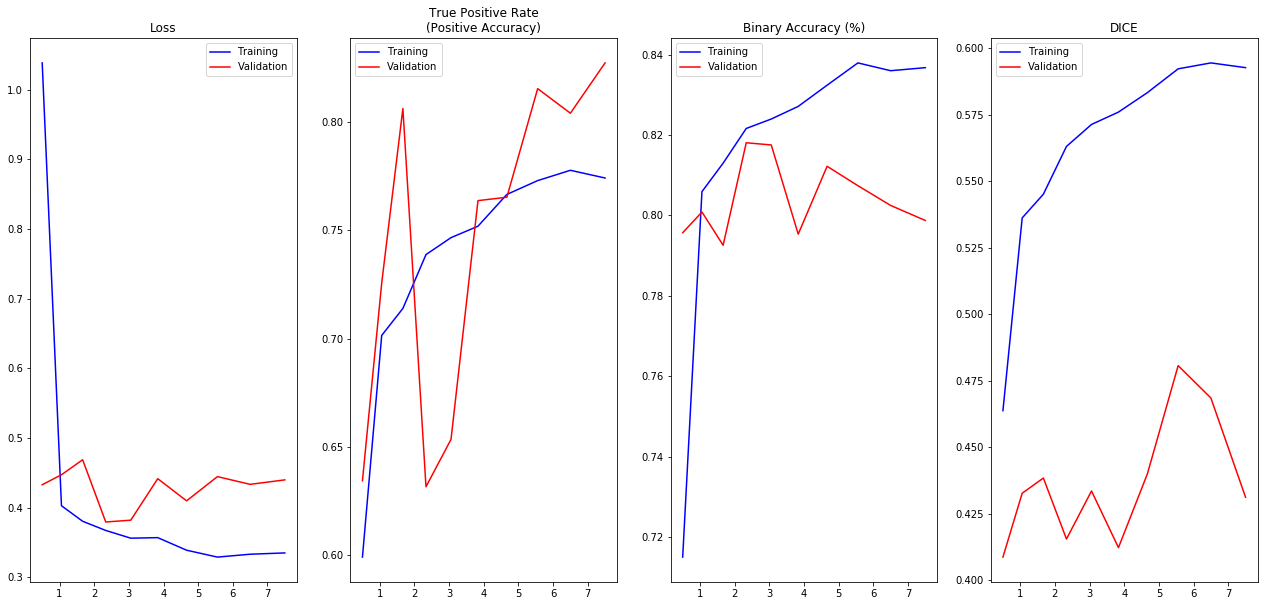

In [8]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [16]:
unet_model.load_weights(weight_path)
unet_model.save('full_seg_model.h5')

## Test Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


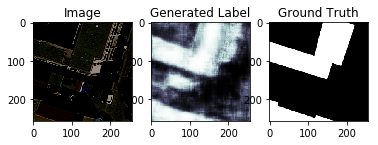

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0020556953 0.9956591


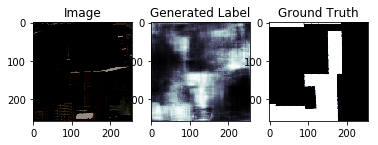

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0012764059 0.9668228


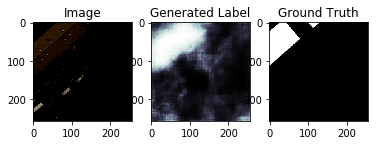

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0005689199 0.99673957


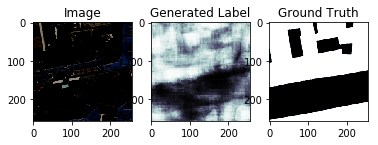

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0074642138 0.9944424


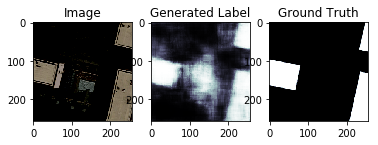

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.001037177 0.9988733


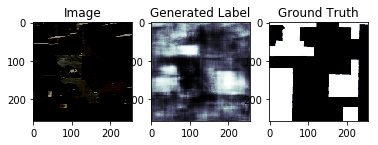

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0057196724 0.9941314


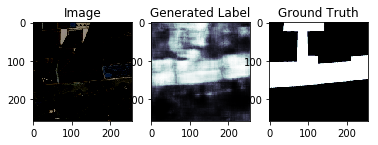

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00028028313 0.9950063


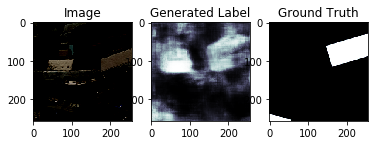

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.000119111806 0.99863225


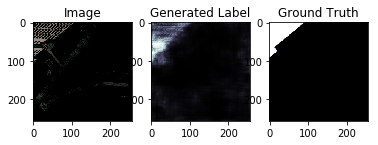

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0014374617 0.96580225


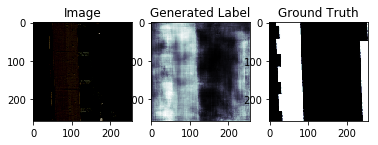

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.006595286 0.9436519


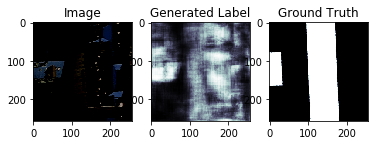

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.009656799 0.99425113


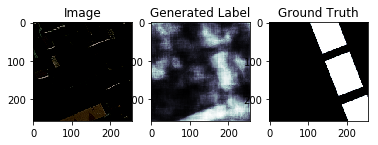

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0048922305 0.9589669


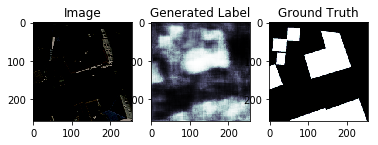

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0024399871 0.9984825


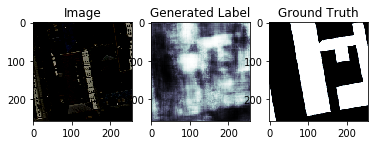

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.010769494 0.99468863


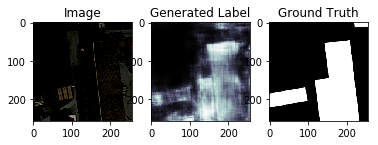

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0004050744 0.9625551


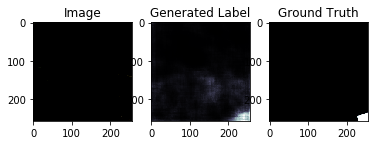

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00030085805 0.8862868


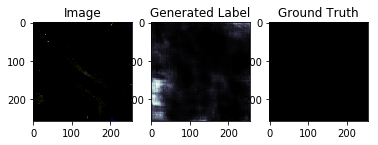

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0011042935 0.8189624


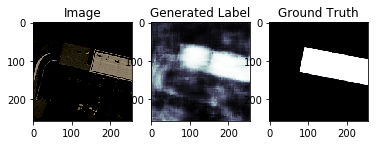

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00094790483 0.99830663


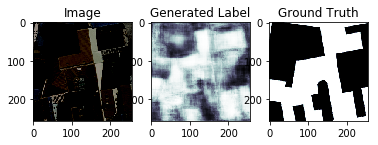

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.016675359 0.9984931


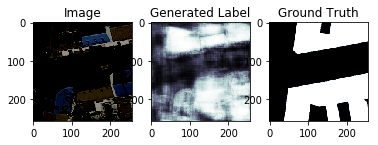

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.01912704 0.9986903


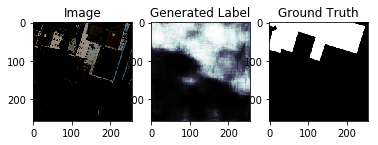

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0012604785 0.9958941


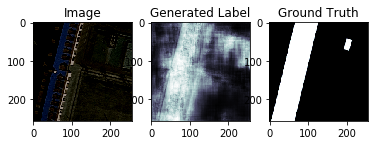

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.01281868 0.9676173


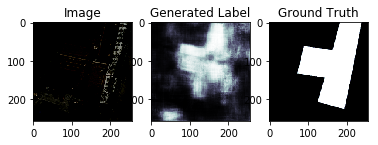

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0012737111 0.9936878


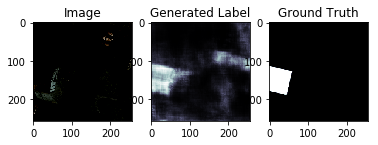

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00067017163 0.9509896


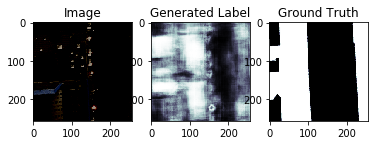

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0147353485 0.9986987


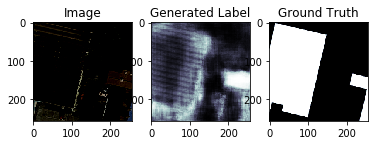

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.008447932 0.99878484


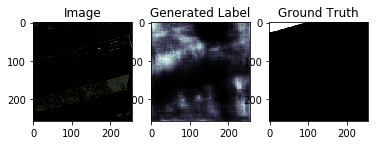

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0011055077 0.9118988


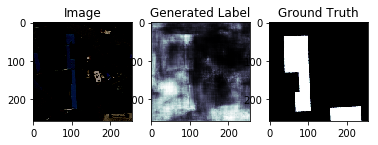

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0013365326 0.9685938


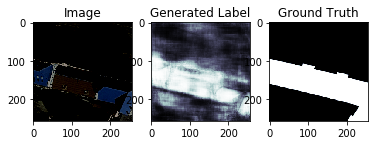

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.003558606 0.99652475


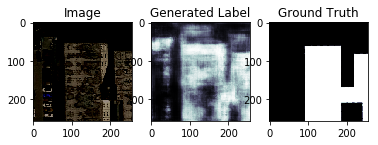

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0014523993 0.9810596


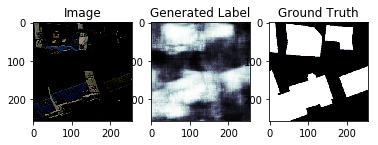

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.007806395 0.99895275


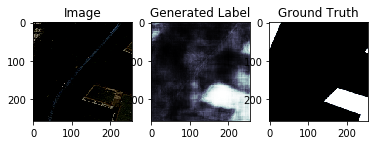

0.00429164 0.9976191


In [9]:
%load_ext autoreload
%autoreload 2

testing_generator = DataGeneratorOSM(partition['test'], labels['test'], **params)
(X,y) = testing_generator. __getitem__(0)
dm_pred = unet_model.predict([X])
for i in range(dm_pred.shape[0]):
    show_sample_gt(X[i,:].astype(int), np.squeeze(dm_pred[i,:]), np.squeeze(y[i,:]))
    print(dm_pred[i,:].min(), dm_pred[i,:].max())
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


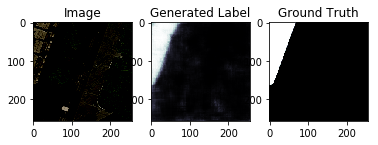

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00044279295 0.99323785


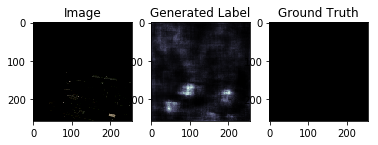

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0010535467 0.48081598


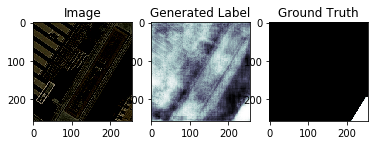

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.088072784 0.99759007


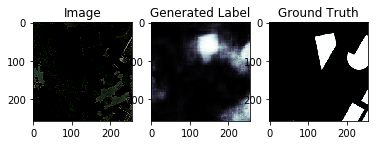

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00037034228 0.9965269


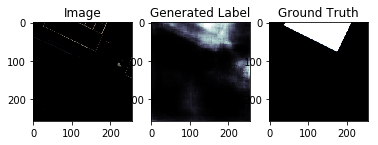

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0002216107 0.9711114


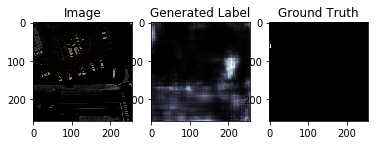

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00025810263 0.89307123


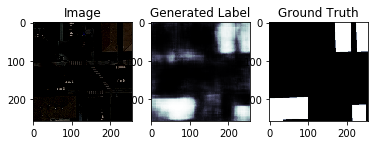

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7.050844e-05 0.9984919


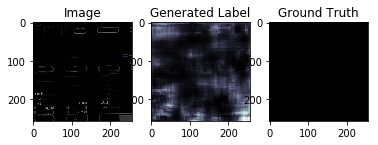

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0038120158 0.8437549


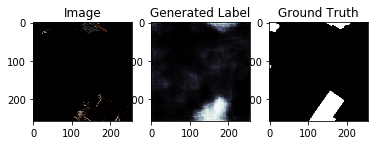

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00072302413 0.9744167


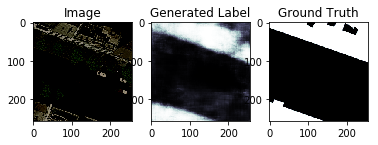

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7.692059e-05 0.9991233


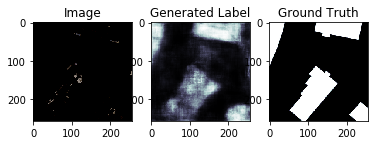

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0023470214 0.9577366


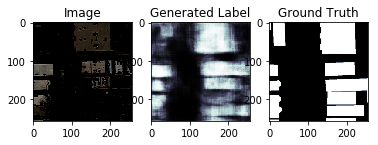

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0022652145 0.999337


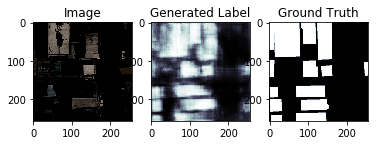

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0016229439 0.9943479


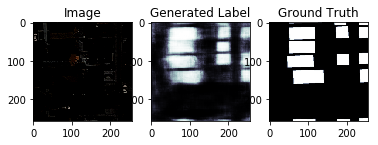

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0004698865 0.99705243


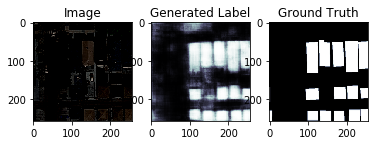

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0014167621 0.99677354


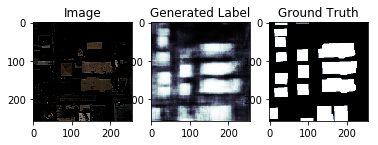

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0030079014 0.99751794


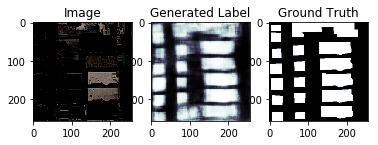

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0011568117 0.9996581


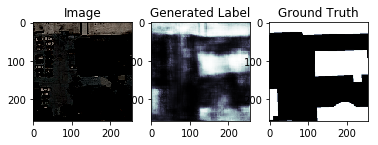

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0014279853 0.9953982


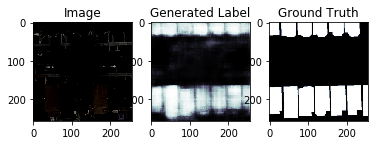

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8.138992e-05 0.99535817


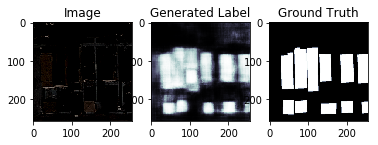

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.4522165e-05 0.9919733


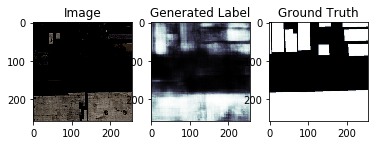

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00068559917 0.9949055


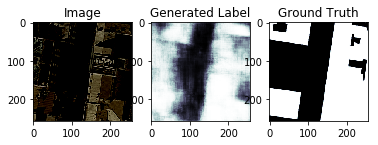

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.01870414 0.9993623


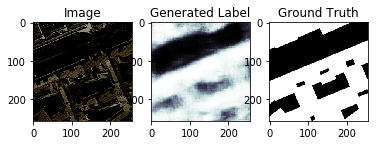

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0017177656 0.99942905


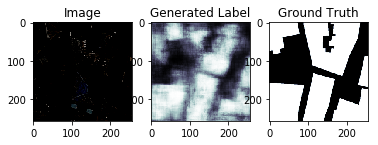

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.007262142 0.99266523


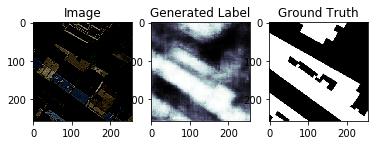

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0034428616 0.9974233


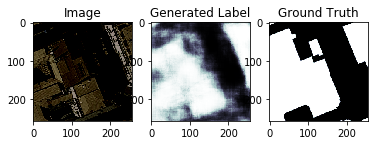

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0012387891 0.9992105


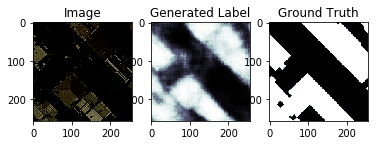

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00060570415 0.9992637


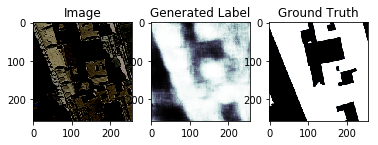

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0019322295 0.9995727


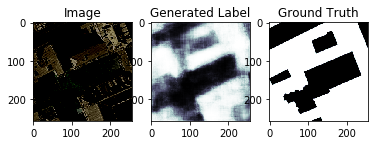

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0047432478 0.9989924


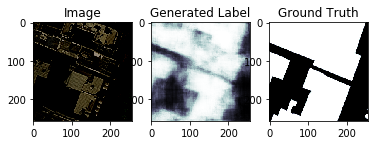

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0062864698 0.9998141


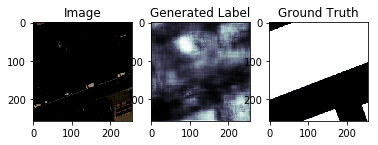

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00079559645 0.95553213


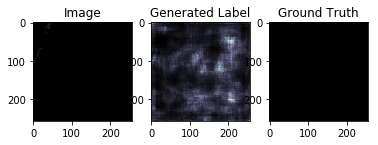

0.0022406986 0.22097792


In [10]:
(X,y) = training_generator. __getitem__(0)
dm_pred = unet_model.predict([X])
for i in range(dm_pred.shape[0]):
    show_sample_gt(X[i,:].astype(int), np.squeeze(dm_pred[i,:]), np.squeeze(y[i,:]))
    print(dm_pred[i,:].min(), dm_pred[i,:].max())
    

In [21]:
# TO DO
# MASK COVERAGE FUNCTION from Maurits - check it
# GENERATE FAKE IMAGES
# MAKE low resolution 128x128
# UNIT test - if masks should be binary. Check values - why the mask is weird? 
# check the loss functions 
# check KERAS Preprocessing



numpy.float64

## evaluate the model results

In [11]:
out_parms = unet_model.evaluate_generator(testing_generator , steps = 10)
print('\n')
for k,v in zip(unet_model.metrics_names, out_parms):
    print(k,'%2.2f' % v)
    



loss 0.38
dice_coef 0.48
binary_accuracy 0.82
true_positive_rate 0.75
